# Assignment: Dino Fun World Time Series Analysis

The administrators of Dino Fun World, a local amusement park, have asked you, one of their data analysts, to perform three data analysis tasks for their park. These tasks will involve understanding, analysing, and graphing attendance data that the park has provided for you to use. They have provided the data in the form of a database, described below.

### Provided Database

The database provided by the park administration is formatted to be readable by any SQL database library. The course staff recommends the sqlite3 library. The database contains three tables, named 'checkins', 'attractions', and 'sequences'. The information contained in each of these tables is listed below:

`checkins`:
    - Description: check-in data for all visitors for the day in the park. The data includes two types of check-ins, inferred and actual checkins.
    - Fields: visitorID, timestamp, attraction, duration, type
`attraction`:
    - The attractions in the park by their corresponding AttractionID, Name, Region, Category, and type. Regions are from the VAST Challenge map such as Coaster Alley, Tundra Land, etc. Categories include Thrill rides, Kiddie Rides, etc. Type is broken into Outdoor Coaster, Other Ride, Carussel, etc.
    - Fields: AttractionID, Name, Region, Category, type
`sequences`:
    - The check-in sequences of visitors. These sequences list the position of each visitor to the park every five minutes. If the visitor has not entered the part yet, the sequence has a value of 0 for that time interval. If the visitor is in the park, the sequence lists the attraction they have most recently checked in to until they check in to a new one or leave the park.
    - Fields: visitorID, sequence
    
The database is named 'dinofunworld.db' and is available in the readonly directory of the Jupyter Notebook environment (i.e. readonly/dinofunworld.db).

### Questions to Answer

1: The park's administrators are worried about the attendance at the ride 'Atmosfear' in the data window. To assuage their fears, they have asked you to create a control chart of the total attendance at this ride. Using the data provided, create a control chart displaying the attendance, the mean, and the standard deviation bands at one and two standard deviations.

2: Some of the park's administrators are having trouble interpreting the control chart graph of 'Atmosfear' attendance, so they ask you to also provide a moving average chart of the attendance in addition to the control chart created in the previous question. In this case, they request that you use 50 samples for the size of the moving average window.

3: In order to have options concerning the graphs presented, the park's administrators also ask you to provide a 50-sample moving average window with the average computed with exponential weighting (i.e. an exponentially-weight moving average) over the same 'Atmosfear' attendance dat.

#### Administrative Notes

This assignment will be graded by Coursera's grading system. In order for your answers to be correctly registered in the system, you must place the code for your answers in the cell indicated for each question. In addition, you should submit the assignment with the output of the code in the cell's display area. The display area should contain only your answer to the question with no extraneous information, or else the answer may not be picked up correctly. Each cell that is going to be graded has a set of comment lines at the beginning of the cell. These lines are extremely important and must not be modified or removed.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('readonly/dinofunworld.db')
cur = con.cursor()

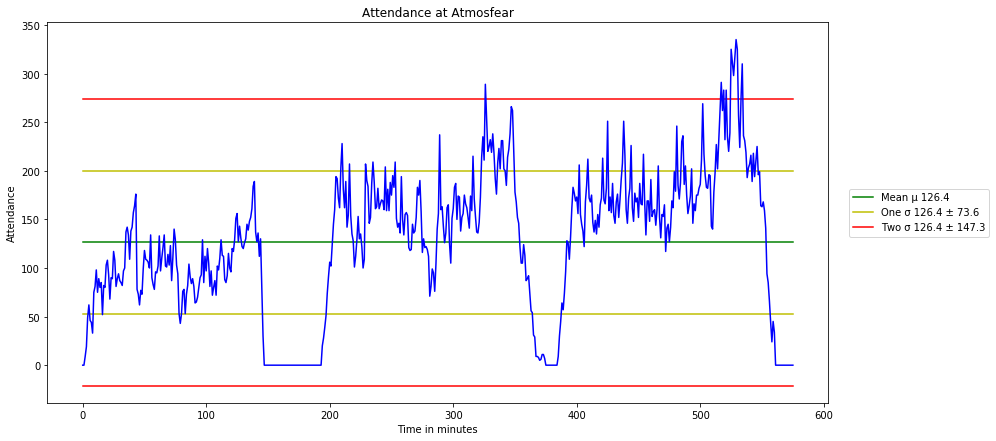

In [85]:
# Graded Part, PartID: BZjRz
# Create and display a control chart showing attendance at the ride 'Atmosfear' over the data provided. In the control
# chart, display the attendance, the mean attendance, and bands for one and two standard deviations away from the average.

cur.execute("""
    SELECT attractionID, Name, visitorID, sequence 
    FROM sequences, (SELECT attractionID, Name
    FROM attraction
    WHERE Name = 'Atmosfear') as Attraction
    WHERE sequence LIKE '%-' || attractionID || '-%' OR
          sequence LIKE attractionID || '-%' OR
          sequence LIKE '%-' || attractionID;
""")

def sequence_to_number_by_filter(sequence, attraction_id):
    count = 0
    for _id_ in sequence:
        if int(_id_) == int(attraction_id):
            count += 1
    return count

atmosfear_data = cur.fetchall()
attendance_data = map(lambda row: (row[2], row[3]), atmosfear_data)

attraction_id, attraction_name = (atmosfear_data[0][0], atmosfear_data[0][1])

sequences = pd.DataFrame.from_records(attendance_data, columns=['visitor', 'sequence'])
sequences['sequence'] = sequences['sequence'].apply(lambda sequence: [1 if attraction == str(attraction_id) else 0 for attraction in sequence.split("-")])
attendances = np.sum(sequences.sequence.values.tolist(), axis=0)

mean = attendances.mean()
stddev = attendances.std()

plt.rcParams["figure.figsize"] = (14,7)
plt.title('Control Chart: Attendance at Atmosfear')
plt.ylabel('Attendance')
plt.xlabel('Time in minutes')

x_axis = range(len(attendances))

plt.plot(x_axis, [mean]*len(x_axis), 'g-', label="Mean μ {:.1f}".format(mean))

plt.plot(x_axis, [mean+stddev]*len(x_axis), 'y-', label="One σ {:.1f} ± {:.1f}".format(mean, stddev))
plt.plot(x_axis, [mean-stddev]*len(x_axis), 'y-')

plt.plot(x_axis, [mean+2*stddev]*len(x_axis), 'r-', label="Two σ {:.1f} ± {:.1f}".format(mean, 2*stddev))
plt.plot(x_axis, [mean-2*stddev]*len(x_axis), 'r-')

plt.plot(x_axis, attendances, 'b-')

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.show()


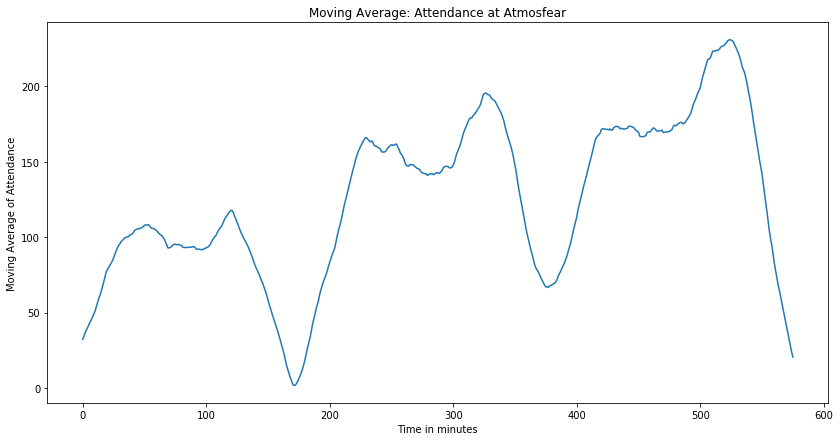

In [89]:
# Graded Part, PartID: Z9m56
# Create and display a moving average chart of the attendance at 'Atmosfear' over the data provided. Use a window size of
# 50 for this moving average.

plt.title('Moving Average: Attendance at Atmosfear')
plt.ylabel('Moving Average of Attendance')
plt.xlabel('Time in minutes')

window_size = 50
plt.plot(x_axis, np.convolve(attendances, np.ones(window_size,)/window_size, 'same'), )
plt.show()

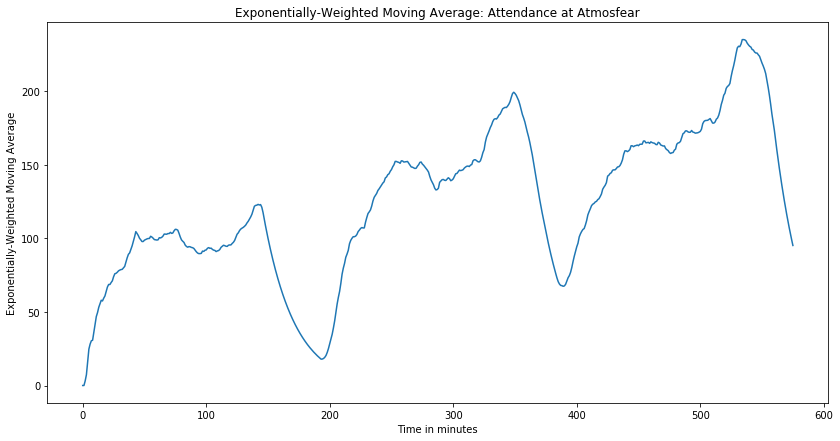

In [90]:
# Graded Part, artID: 3KxS2
# Create and display an exponentially-weighted moving average chart of the attendance at 'Atmosfear' over the data provided.
# Again, use a window size of 50 for this weighted moving average.

df = pd.DataFrame(data=attendances)
df_exp = df.ewm(span=50).mean()

plt.title('Exponentially-Weighted Moving Average: Attendance at Atmosfear')
plt.ylabel('Exponentially-Weighted Moving Average')
plt.xlabel('Time in minutes')

plt.plot(df_exp)
plt.show()